<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [35]:
## install finrl library
# %pip install git+https://github.com/shnkar-roy/FinRL.git

In [36]:
from finrl import config
from finrl import config_tickers
import time
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

#import sys
#sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [38]:
# from config.py start_date is a string, not provided now
START_DATE='2008-01-01'

In [39]:
# from config.py end_date is a string, not provided now
END_DATE=datetime.datetime.now().strftime('%Y-%m-%d')

In [40]:
quotes_filename = "." + os.sep + config.DATA_SAVE_DIR + os.sep + "quotes.csv"

In [41]:
try:
    df = pd.read_csv(quotes_filename)
except FileNotFoundError as e:
    print("File not found, need to download data...")
    df = YahooDownloader(start_date = START_DATE, # '2009-01-01',
                         end_date = END_DATE, # '2022-08-31',
                         ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
    df.sort_values(['date', 'tic'], ignore_index=True)
    # df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    # df.set_index('date')
    df.to_csv(quotes_filename)

File not found, need to download data...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 com

In [42]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [43]:
df.shape

(108005, 8)

In [44]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.941449,1079178800,AAPL,2
1,2008-01-02,46.599998,47.040001,46.259998,35.172176,7934400,AMGN,2
2,2008-01-02,52.090000,52.320000,50.790001,40.326859,8053700,AXP,2
3,2008-01-02,87.570000,87.839996,86.000000,63.481613,4303000,BA,2
4,2008-01-02,72.559998,72.669998,70.050003,46.850498,6337800,CAT,2


In [45]:
#df.to_csv(quotes_filename)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [46]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3695, 8)
Successfully added vix
Successfully added turbulence index


In [47]:
processed.shape

(103460, 18)

In [48]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [49]:
len(combination)

150024

In [50]:
print(list_ticker)

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'WBA', 'WMT']


In [51]:
len(list_ticker)

28

In [52]:
len(list_date)

5358

In [53]:
list_date[0]

'2008-01-02'

In [54]:
list_date[len(list_date)-1]

'2022-09-02'

In [55]:
processed_full.shape

(103460, 18)

In [56]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(40)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
103420,2022-09-01,KO,61.580002,62.040001,61.290001,62.000000,14939700.0,3.0,-0.220363,65.853359,61.543641,46.273194,-150.931620,30.239619,63.598333,62.757418,25.559999,19.085405
103421,2022-09-01,MCD,251.820007,256.529999,251.759995,256.470001,2577800.0,3.0,-0.286057,267.748174,250.925197,51.773037,-93.879904,24.759759,258.926518,252.363199,25.559999,19.085405
103422,2022-09-01,MMM,124.300003,126.389999,123.669998,125.629997,31014400.0,3.0,-3.426948,159.327370,122.515234,38.167046,-178.031783,45.241533,140.410049,135.559496,25.559999,19.085405
103423,2022-09-01,MRK,85.639999,87.459999,85.360001,87.150002,7528600.0,3.0,-0.788663,92.970933,85.844066,45.543693,-132.959618,30.784489,89.372333,89.965193,25.559999,19.085405
103424,2022-09-01,MSFT,258.869995,260.890015,255.410004,260.399994,23263400.0,3.0,-2.529663,301.191415,257.764463,44.671480,-133.392896,38.001442,276.657870,267.030751,25.559999,19.085405
103425,2022-09-01,NKE,105.800003,106.550003,103.800003,106.184998,5590800.0,3.0,-1.064436,119.078931,104.727220,44.873613,-149.542838,23.767189,111.610416,109.676804,25.559999,19.085405
103426,2022-09-01,PG,137.830002,139.759995,136.759995,139.639999,7446500.0,3.0,-1.117110,152.615632,138.326367,44.134509,-162.223431,36.873491,144.923000,142.948968,25.559999,19.085405
103427,2022-09-01,TRV,161.220001,164.300003,160.410004,163.300003,1041300.0,3.0,0.206828,176.909100,158.003900,47.305033,-20.030217,25.437729,164.286334,164.561667,25.559999,19.085405
103428,2022-09-01,UNH,519.330017,524.260010,515.090027,524.000000,2085300.0,3.0,-0.631159,553.606879,520.002123,50.184096,-180.303526,27.147932,536.074668,518.049251,25.559999,19.085405
103429,2022-09-01,VZ,41.639999,42.049999,41.639999,41.810001,21641700.0,3.0,-1.194271,46.395921,41.795080,33.014860,-213.257726,54.553258,44.468333,47.255278,25.559999,19.085405


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2021-12-31
## Trade data split: 2022-01-01 to 2022-08-31

In [57]:
train = data_split(processed_full, '2008-01-01','2021-12-31')
trade = data_split(processed_full, '2022-01-01','2022-08-31')
print(len(train))
print(len(trade))

98700
4648


In [58]:
train.tail(40)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3523,2021-12-29,KO,58.950001,59.099998,58.660000,58.082535,9996000.0,2.0,1.010698,59.962508,51.705720,62.256096,114.141185,33.529540,55.167394,54.572205,16.950001,6.343448
3523,2021-12-29,MCD,268.450012,269.720001,267.950012,264.087463,1318500.0,2.0,4.317660,270.172024,243.652174,64.086558,111.625714,34.956619,253.542452,247.283945,16.950001,6.343448
3523,2021-12-29,MMM,177.479996,178.889999,177.229996,173.157043,1221900.0,2.0,-0.233469,174.518508,165.221992,50.377038,54.113182,5.331517,170.842579,172.253203,16.950001,6.343448
3523,2021-12-29,MRK,76.800003,77.180000,76.470001,75.652397,5926100.0,2.0,-0.391396,76.794348,69.502571,49.598712,8.317534,5.372070,74.935568,77.703552,16.950001,6.343448
3523,2021-12-29,MSFT,341.299988,344.299988,339.679993,339.730377,15042000.0,2.0,2.300337,343.945749,316.353131,57.987215,101.276461,19.847553,331.859765,322.619931,16.950001,6.343448
3523,2021-12-29,NKE,167.070007,169.800003,166.600006,167.498444,3830900.0,2.0,-0.423074,172.127651,158.509196,52.949171,-0.830063,14.420131,166.854654,163.991513,16.950001,6.343448
3523,2021-12-29,PG,163.210007,164.979996,163.080002,161.349686,5346100.0,2.0,3.812722,163.532644,143.663631,70.537056,139.657284,62.214721,150.721444,145.551958,16.950001,6.343448
3523,2021-12-29,TRV,157.649994,158.000000,157.119995,155.849167,683400.0,2.0,0.596577,160.347799,144.769947,52.274621,69.404607,2.941862,152.639299,154.066289,16.950001,6.343448
3523,2021-12-29,UNH,504.779999,507.220001,502.000000,502.296997,1573900.0,2.0,13.522901,513.735318,438.288840,68.767862,127.760571,45.467053,464.529503,449.138637,16.950001,6.343448
3523,2021-12-29,VZ,52.770000,52.880001,52.340000,50.479187,15109500.0,2.0,0.290739,52.002026,47.404181,50.642500,80.875877,2.883501,49.671611,50.209250,16.950001,6.343448


In [59]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,AAPL,177.830002,182.880005,177.710007,181.259933,104487900.0,0.0,4.808605,183.080385,166.453220,64.844827,102.707255,50.480448,170.210325,159.073256,16.6,39.438443
0,2022-01-03,AMGN,223.630005,226.970001,222.029999,221.262680,2742800.0,0.0,4.729835,226.474642,201.962276,60.592155,90.863766,30.885704,208.701451,205.503746,16.6,39.438443
0,2022-01-03,AXP,164.509995,168.399994,164.399994,166.690140,3236400.0,0.0,-0.654658,168.474023,156.073788,50.972520,59.472744,4.683067,161.584028,168.675533,16.6,39.438443
0,2022-01-03,BA,204.000000,210.550003,203.339996,207.860001,9060200.0,0.0,-0.982440,213.990814,188.896187,49.747896,65.232126,14.369636,201.908335,210.063501,16.6,39.438443
0,2022-01-03,CAT,207.330002,208.600006,205.800003,203.599182,2055600.0,0.0,1.337452,206.519498,194.069257,53.031053,98.501540,13.202355,198.749514,198.607793,16.6,39.438443


In [60]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [61]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 28, State Space: 281


In [62]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100_000, #and hold no shares at beginning.
    #"initial_list": [1000000] + [0 for i in range(stock_dimension)],
    # buy and sell cost for each stock
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)


In [63]:
train.shape

(98700, 18)

## Environment for Training



In [64]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [65]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


In [66]:
tensorboard_log_dir = "." + os.sep + config.TENSORBOARD_LOG_DIR + os.sep + "{}".format(time.strftime("%Y%m%d-%H%M"))

### Model 1: A2C


In [67]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", verbose=1, tensorboard_log=tensorboard_log_dir)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [68]:
model_a2c.reset_num_timesteps=False
TIME_STEPS = 50_000
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=TIME_STEPS)

Logging to .\tensorboard_log\20220907-0759\a2c_1
---------------------------------------
| time/                 |             |
|    fps                | 81          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -39.9       |
|    explained_variance | -12.2       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 14.2        |
|    reward             | 0.015655594 |
|    std                | 1.01        |
|    value_loss         | 0.145       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 70          |
|    iterations         | 200         |
|    time_elapsed       | 14          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -40.1

In [69]:
# trained_a2c = agent.train_model(model=model_a2c,
#                                 tb_log_name='a2c',
#                                 total_timesteps=50000)

In [70]:
trained_a2c.save("." + os.sep + config.TRAINED_MODEL_DIR + os.sep + "a2c.pkl")

### Model 2: DDPG

In [71]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg", verbose=1, tensorboard_log=tensorboard_log_dir)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [72]:
TIME_STEPS = 100_000
model_ddpg.reset_num_timesteps=False
trained_ddpg = agent.train_model(model=model_ddpg,
                            tb_log_name='ddpg',
                            total_timesteps=TIME_STEPS)
# trained_ddpg = agent.train_model(model=model_ddpg,
#                                 tb_log_name='ddpg',
#                                 total_timesteps=50000)

Logging to .\tensorboard_log\20220907-0759\ddpg_1
day: 3524, episode: 20
begin_total_asset: 100000.00
end_total_asset: 99900.10
total_reward: -99.90
total_cost: 99.90
total_trades: 52860
Sharpe: 0.240
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 68           |
|    time_elapsed    | 206          |
|    total_timesteps | 14100        |
| train/             |              |
|    actor_loss      | -2.36        |
|    critic_loss     | 0.0345       |
|    learning_rate   | 0.001        |
|    n_updates       | 10575        |
|    reward          | -0.011452495 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 63           |
|    time_elapsed    | 442          |
|    total_timesteps | 28200        |
| train/             |              |
|    actor_loss      | -1.03        |
|

In [73]:
trained_ddpg.save("." + os.sep + config.TRAINED_MODEL_DIR + os.sep + "ddpg.pkl")

### Model 3: PPO

In [74]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,
                            verbose=1, tensorboard_log=tensorboard_log_dir)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [75]:
TIME_STEPS = 50_000
model_ppo.reset_num_timesteps=False
trained_ppo = agent.train_model(model=model_ppo,
                                 tb_log_name='ppo',
                                 total_timesteps=TIME_STEPS)
# trained_ppo = agent.train_model(model=model_ppo,
#                             tb_log_name='ppo',
#                             total_timesteps=50000)

Logging to .\tensorboard_log\20220907-0759\ppo_1
-----------------------------------
| time/              |            |
|    fps             | 87         |
|    iterations      | 1          |
|    time_elapsed    | 23         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.04141144 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 2           |
|    time_elapsed         | 47          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020700984 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -1.51       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.455      |
|    n_updates            | 10         

In [76]:
trained_ppo.save("." + os.sep + config.TRAINED_MODEL_DIR + os.sep + "ppo.pkl")

### Model 4: TD3

In [77]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS,
                            verbose=1, tensorboard_log=tensorboard_log_dir)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [78]:
TIME_STEPS = 50_000
model_td3.reset_num_timesteps=False
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=TIME_STEPS)
# trained_td3 = agent.train_model(model=model_td3,
#                                 tb_log_name='td3',
#                                 total_timesteps=30000)

Logging to .\tensorboard_log\20220907-0759\td3_1
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 68           |
|    time_elapsed    | 206          |
|    total_timesteps | 14100        |
| train/             |              |
|    actor_loss      | 1.12         |
|    critic_loss     | 0.0949       |
|    learning_rate   | 0.001        |
|    n_updates       | 10575        |
|    reward          | -0.011865147 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 64           |
|    time_elapsed    | 435          |
|    total_timesteps | 28200        |
| train/             |              |
|    actor_loss      | 1.2          |
|    critic_loss     | 0.0163       |
|    learning_rate   | 0.001        |
|    n_updates       | 24675        |
|    reward          | -0.011865147 |
-

In [79]:
trained_td3.save("." + os.sep + config.TRAINED_MODEL_DIR + os.sep + "td3.pkl")

### Model 5: SAC

In [80]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS,
                            verbose=1, tensorboard_log=tensorboard_log_dir)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [81]:
TIME_STEPS = 50_000
model_sac.reset_num_timesteps=False
trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=TIME_STEPS)
# trained_sac = agent.train_model(model=model_sac,
#                                 tb_log_name='sac',
#                                 total_timesteps=60000)

Logging to .\tensorboard_log\20220907-0759\sac_1
day: 3524, episode: 80
begin_total_asset: 100000.00
end_total_asset: 38943.06
total_reward: -61056.94
total_cost: 44084.60
total_trades: 63687
Sharpe: 0.029
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 35           |
|    time_elapsed    | 400          |
|    total_timesteps | 14100        |
| train/             |              |
|    actor_loss      | -15.5        |
|    critic_loss     | 4.2          |
|    ent_coef        | 0.0256       |
|    ent_coef_loss   | -170         |
|    learning_rate   | 0.0001       |
|    n_updates       | 13999        |
|    reward          | -0.010065694 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 34           |
|    time_elapsed    | 805          |
|    total_timesteps | 28200      

In [82]:
trained_sac.save("." + os.sep + config.TRAINED_MODEL_DIR + os.sep + "sac.pkl")

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [83]:
data_risk_indicator = processed_full[(processed_full.date<'2021-01-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [84]:
insample_risk_indicator.vix.describe()

count    3021.000000
mean       19.116220
std         8.458954
min         9.140000
25%        13.410000
50%        16.440001
75%        22.219999
max        82.690002
Name: vix, dtype: float64

In [85]:
insample_risk_indicator.vix.quantile(0.996)

57.078401794433596

In [86]:
insample_risk_indicator.turbulence.describe()

count    3021.000000
mean       35.089819
std        42.031465
min         0.000000
25%        15.881325
50%        24.025809
75%        38.396066
max       639.326079
Name: turbulence, dtype: float64

In [87]:
insample_risk_indicator.turbulence.quantile(0.996)

272.7496549014026

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [88]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [89]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,AAPL,177.830002,182.880005,177.710007,181.259933,104487900.0,0.0,4.808605,183.080385,166.453220,64.844827,102.707255,50.480448,170.210325,159.073256,16.6,39.438443
0,2022-01-03,AMGN,223.630005,226.970001,222.029999,221.262680,2742800.0,0.0,4.729835,226.474642,201.962276,60.592155,90.863766,30.885704,208.701451,205.503746,16.6,39.438443
0,2022-01-03,AXP,164.509995,168.399994,164.399994,166.690140,3236400.0,0.0,-0.654658,168.474023,156.073788,50.972520,59.472744,4.683067,161.584028,168.675533,16.6,39.438443
0,2022-01-03,BA,204.000000,210.550003,203.339996,207.860001,9060200.0,0.0,-0.982440,213.990814,188.896187,49.747896,65.232126,14.369636,201.908335,210.063501,16.6,39.438443
0,2022-01-03,CAT,207.330002,208.600006,205.800003,203.599182,2055600.0,0.0,1.337452,206.519498,194.069257,53.031053,98.501540,13.202355,198.749514,198.607793,16.6,39.438443


In [90]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [91]:
df_account_value.shape

(166, 2)

In [92]:
df_account_value.tail()

,date,account_value
161,2022-08-24,92758.138510
162,2022-08-25,93515.852631
163,2022-08-26,91118.279554
164,2022-08-29,90861.016118
165,2022-08-30,89924.890643


In [93]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0,61,0,46,0,0,0,0,0,0,61,0,0,0,0,0,0,72,0,0,0,0,64,0,39,0,66,0
2022-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [94]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.148889
Cumulative returns    -0.100751
Annual volatility      0.181628
Sharpe ratio          -0.802130
Calmar ratio          -0.849050
Stability              0.156652
Max drawdown          -0.175359
Omega ratio            0.879248
Sortino ratio         -1.060835
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.846785
Daily value at risk   -0.023461
dtype: float64


In [95]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (165, 8)
Annual return         -0.181098
Cumulative returns    -0.122620
Annual volatility      0.193603
Sharpe ratio          -0.941352
Calmar ratio          -0.964327
Stability              0.492524
Max drawdown          -0.187797
Omega ratio            0.856847
Sortino ratio         -1.245503
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.774852
Daily value at risk   -0.025115
dtype: float64


In [96]:
df_account_value.loc[0,'date']

'2022-01-03'

In [97]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-08-30'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (165, 8)


Start date,2022-01-03
End date,2022-08-30
Total months,7
,Backtest
Annual return,-14.889%
Cumulative returns,-10.075%
Annual volatility,18.163%
Sharpe ratio,-0.80
Calmar ratio,-0.85
Stability,0.16
Max drawdown,-17.536%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.54,2022-01-04,2022-06-17,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-08-30 00:00:00+0000', tz='UTC'))

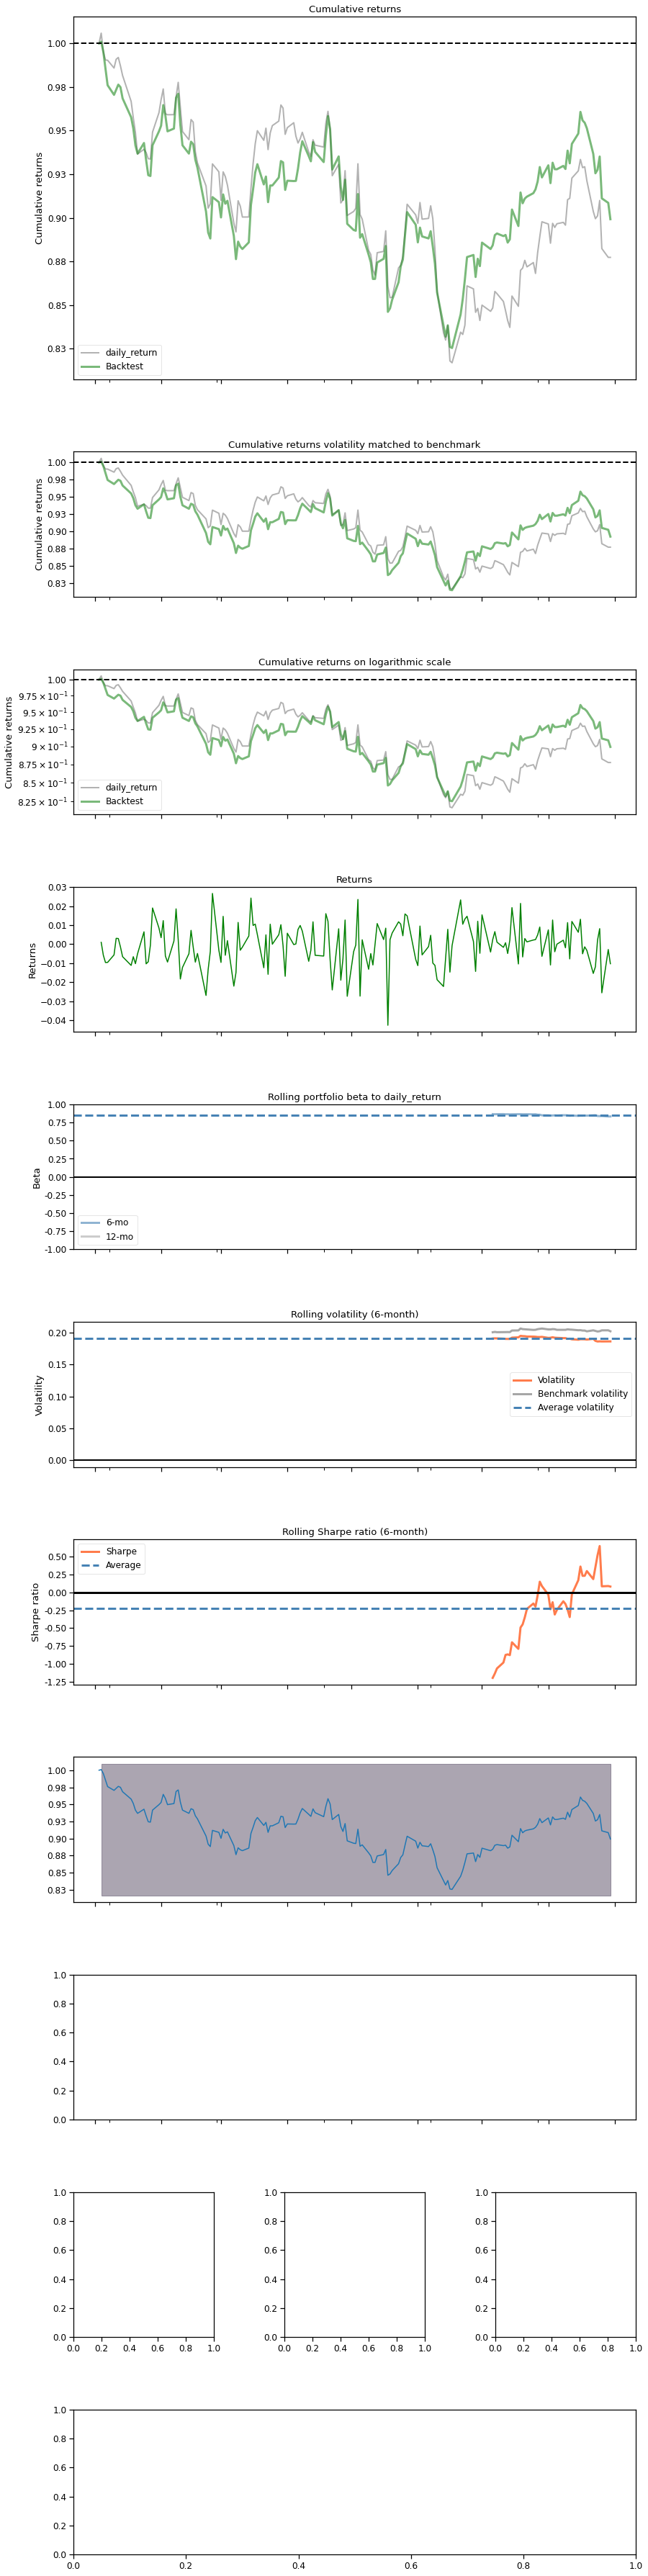

In [98]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])